### Importación de librerías

In [67]:
from bs4 import BeautifulSoup # Herramienta de web scrapping

import requests # Herramienta para consultar paginas web

import pandas as pd # Herramienta de manipulacion de datos (reemplaza a excel)

import random # Generación de números aleatorios

from datetime import datetime # Herramienta para trabajar con fechas

from lxml import etree

# Herramienta de visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Para texto
import re # Herramienta para expresiones regulares
import nltk
from nltk.corpus import stopwords # Herramienta de procesamiento de lenguaje natural
from unidecode import unidecode # Traduce caracateres especiales
import sklearn
import joblib

In [68]:
sns.set(style="ticks", color_codes=True) # Estilo de gráficos
%matplotlib inline # Visualizar los gráficos dentro del notebook

UsageError: unrecognized arguments: # Visualizar los gráficos dentro del notebook


In [69]:
nltk.download('stopwords') #Descarga de stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Importación de datos

In [70]:
df = pd.read_csv('../src/data/test.csv')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [72]:
df.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


#### Ahora calculemos el sentimiento de estos comentarios
Debemos seguir los siguientes pasos:

1. Obtener un diccionario de palabras positivas y negativas
2. Limpiar las palabras del diccionario y los comentarios
3. Calcular el numero de palabras asociadas a cada sentimiento por comentario
4. Visualizar el resultado

In [73]:
# Cargamos las palabras y su sentimiento
#words_sentiment = pd.read_csv('../src/data/words_sentiment.csv')
p_w = pd.read_csv('../src/data/positive words.csv', usecols=[1], names=["word"]) #Palabras positivas
n_w = pd.read_csv('../src/data/negative words.csv',  encoding = "ISO-8859-1", usecols=[1], names=["word"]) #Palabras negativas

In [74]:
#Añadiendo columna con valores para clasificar las palabras
p_w['sentiment'] = 'positive' 
n_w['sentiment'] = 'negative'

In [76]:
words_sentiment = pd.concat([p_w,n_w])

In [77]:
# Obtenemos informacion general de los datos
words_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6786 entries, 0 to 4780
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       6786 non-null   object
 1   sentiment  6786 non-null   object
dtypes: object(2)
memory usage: 159.0+ KB


In [78]:
# Obtenemos un vistazo de las primeras 5 filas de los datos
words_sentiment.head()

,word,sentiment
0,abound,positive
1,abounds,positive
2,abundance,positive
3,abundant,positive
4,accessable,positive


In [79]:
# Limpiamos las palabras del diccionario
words_sentiment['word'] = words_sentiment['word'].apply(unidecode) # Elimina caracteres especiales
words_sentiment['word'] = words_sentiment['word'].str.lower() # Pone todo en minusculas

In [80]:
# Lista de palabras positivas
pos_words = words_sentiment[words_sentiment['sentiment'] == 'positive']
pos_words = pos_words['word'].values.tolist()

# Lista de palabras negativas
neg_words = words_sentiment[words_sentiment['sentiment'] == 'negative']
neg_words = neg_words['word'].values.tolist()

#### Ahora seleccionaremos un comentario como ejemplo

In [81]:
text = df.loc[20,'tweet']
print(text)

hey guys tommorow is the last day of my exams i'm so happy yay  


In [82]:
# Limpiamos el comentario
text_ = unidecode(text) # Elimina caracateres especiales
text_ = re.sub("[^ a-zA-Z]", "", text_) # Elimina puntuacion y otros
text_ = text_.lower() # Pone todo en minúsculas
print(text_)

hey guys tommorow is the last day of my exams im so happy yay  


In [83]:
tokens = text_.split(" ") # Separa las palabras por espacios -> lista de tokens            
print(tokens)

['hey', 'guys', 'tommorow', 'is', 'the', 'last', 'day', 'of', 'my', 'exams', 'im', 'so', 'happy', 'yay', '', '']


In [84]:
# Obten las palabras stopwords
stopwords_set = set(stopwords.words("english")) 
# Eliminamos las palabras stopwords
clean_words = [t for t in tokens if not t in stopwords_set]
print(clean_words)

['hey', 'guys', 'tommorow', 'last', 'day', 'exams', 'im', 'happy', 'yay', '', '']


In [85]:
# Conteo de palabras positivas y negativas
pos_word_count = 0
neg_word_count = 0

for word in clean_words:
    if word in pos_words:
        pos_word_count += 1
    if word in neg_words:
        neg_word_count += 1

print('# de palabras positivas: ', pos_word_count)
print('# de palabras negativas: ', neg_word_count)

# de palabras positivas:  2
# de palabras negativas:  0


#### Ahora haremos el procedimiento para todos los comentarios ...
... para hacer esto mas simple utilizaremos funciones

In [86]:
def clean_text(text):
    # Eliminar caracteres que no sean a-z y A-Z => https://regexr.com/
    text_ = unidecode(text)
    text_ = re.sub("[^ a-zA-Z]", "", text_)
    text_ = text_.lower()
    
    # Tokeniza el texto
    tokens = text_.split(" ")              
    
    # Obtenemos la lista de stopwords
    stopwords_set = set(stopwords.words("english"))
    
    # Eliminamos las palabras stopwords del texto
    clean_words = [token for token in tokens if not token in stopwords_set]
    
    return clean_words

In [87]:
def get_sentiment(text, pos_words, neg_words):
    # Conteo de palabras positivas y negativas
    pos_word_count = 0
    neg_word_count = 0
    
    for word in text:
        if word in pos_words:
            pos_word_count += 1
        if word in neg_words:
            neg_word_count += 1
            
    if (pos_word_count - neg_word_count) == 0:
        sentiment = 'neutro'
    if (pos_word_count - neg_word_count) > 0:
        sentiment = 'positive'
    if (pos_word_count - neg_word_count) < 0:
        sentiment = 'negative'
    
    return sentiment

In [88]:
# Limpiamos todos los comentarios
clean_comments = df['tweet'].apply(clean_text)

In [89]:
clean_comments.head()

0    [studiolife, aislife, requires, passion, dedic...
1    [, user, white, supremacists, want, everyone, ...
2    [safe, ways, heal, acne, , , , altwaystoheal, ...
3    [hp, cursed, child, book, reservations, alread...
4    [, , rd, bihday, amazing, hilarious, nephew, e...
Name: tweet, dtype: object

In [90]:
# Calculamos el sentimiento para todos los comentarios
comment_sentiment = clean_comments.apply(func=get_sentiment,
                                         pos_words=pos_words,
                                         neg_words=neg_words)

In [91]:
# Contamos el numero de comentario por tipo de sentimiento
comment_sentiment.value_counts()

positive    7378
neutro      6752
negative    3067
Name: tweet, dtype: int64

In [92]:
# Calculamos la proporcion (~porcentaje) de comentarios por tipo de sentimiento
comment_sentiment.value_counts(normalize=True)

positive    0.429028
neutro      0.392627
negative    0.178345
Name: tweet, dtype: float64

#### Podemos visualizar facilmente nuestros resultados utilizando librerias como matplotlib, seaborn, plotly, entre otras

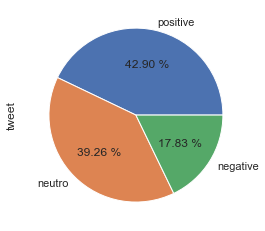

In [93]:
# Visualizacion de los resultados en un grafico de pie
sent_props = comment_sentiment.value_counts(normalize=True) 
sent_props.plot.pie(autopct="%0.2f %%")
plt.show()

### REVISAR CLASSIFIER

In [94]:
sklearn.__version__

'1.1.1'

In [95]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Ya realizamos el trabajo duro!
... Sin embargo, sabemos que existen muchos casos especiales que no hemos considerado, no estamos seguros de que tenemos todas las palabras posibles (de hecho podemos comprobarlo). Entonces, ¿Qué podemos hacer?

##### No reinventemos la rueda..
Una búsqueda rápida de lo que queremos hacer puede ahorrarnos horas de desarrollo al encontrar una o más herramientas que ya están listas para usar.

En este caso hemos encontrado en Github a senti-py un clasificador pre-entrenado de análisis de sentimiento en español, que ya tiene implementado una serie de pasos de limpieza de texto en español y esta entrenado en un enorme corpus de texto en español de diversas fuentes online.

In [96]:
# Importamos la libreria
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [97]:
# Instaciamos el modelo de clasificación
#clf = SentimentClassifier()
sid = SentimentIntensityAnalyzer()

In [98]:
# Recordemos el texto de ejemplo
text

"hey guys tommorow is the last day of my exams i'm so happy yay  "

In [99]:
# Realizamos la clasificacion con el método "predict"
# clf.predict(text)
sid.polarity_scores(text)

{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.8562}

In [100]:
sid.polarity_scores(text).get('compound')

0.8562

In [101]:
# Ahora lo aplicamos a todos los comentarios
new_sentiment_base = df['tweet'].apply(sid.polarity_scores)

In [102]:
new_sentiment_base[1]

{'neg': 0.116, 'neu': 0.809, 'pos': 0.075, 'compound': -0.1779}

In [103]:
#Queremos obtener solo el resultado de cada palabra
new_sentiment_base[1].values()

dict_values([0.116, 0.809, 0.075, -0.1779])

In [104]:
new_sentiment_base[1].get('compound')

-0.1779

In [105]:
new_sentiment = pd.Series(i.get('compound') for i in new_sentiment_base)

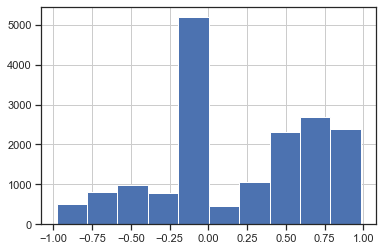

In [106]:
# Debido a que la clasificacion es en valores continuos 
# podemos visualizar la distribución de los datos en un histograma
new_sentiment.hist()
plt.show()

e:\Personal\python\sentiment_analysis\sentiment_analysis\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


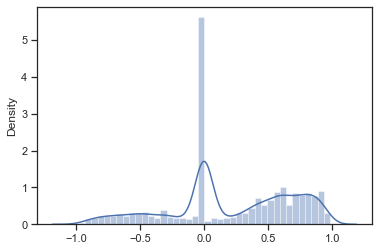

In [107]:
g = sns.distplot(new_sentiment)

In [122]:
# Para simplificar el analisis definiremos 3 rangos de sentimiento
labels = ['negative','neutro','positive']
bins = [-1.1, -0.3, 0.3, 1.1]
new_sentiment_cat = pd.cut(new_sentiment, bins, labels=labels)

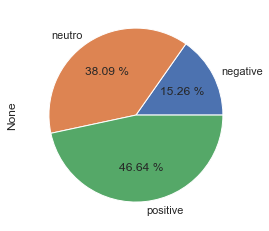

In [123]:
# Visualización de los resultados en un gráfico de pie
new_sent_props = new_sentiment_cat.value_counts(normalize=True)
# Utilicemos el mismo orden que en el gráfico de pie anterior
new_sent_props = new_sent_props[['negative', 'neutro','positive']]
new_sent_props.plot.pie(autopct="%0.2f %%")#, colors=Red)
plt.show()

### Analizemos más a fondo cada categoría
Existen otras posibilidades de visualización cuando se tratan de datos texuales como por ejemplo una nube de palabras frecuentes.

#### Nubes de palabras
Este tipo de visualización te permite tener un vistazo rápido de cuales son las palabras más usadas con respecto a un tópico o en este caso con respecto a un sentimiento.

Ahora realizaremos una nubbe de palabras para cada categoria de sentimiento..

In [110]:
# Separamos los comentarios en cada categoría
positive_texts = df['tweet'][new_sentiment_cat=='positive']
neutral_texts = df['tweet'][new_sentiment_cat=='neutro']
negative_texts = df['tweet'][new_sentiment_cat=='negative']

In [111]:
# Importamos la librería
from wordcloud import WordCloud

In [112]:
# Funciones de ayuda para darle color a las nubes

def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return f'hsl({random.randint(350,360)}, {random.randint(40, 100)}%, {random.randint(50, 100)}%)'


def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return f'hsl({random.randint(100,130)}, {random.randint(40, 100)}%, {random.randint(50, 100)}%)'

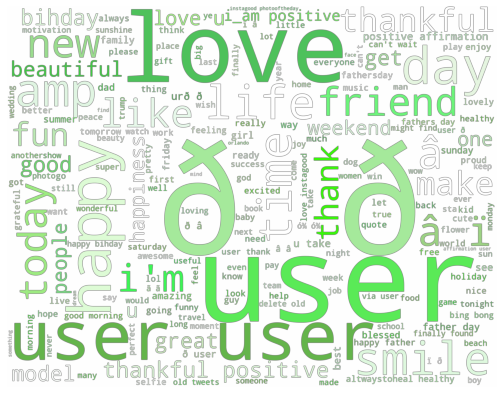

In [113]:
# Une todos los comentarios en un solo texto (formato de la librería)
positive_words =' '.join([text for text in positive_texts]) 

# Se contruye la nuba de palabras
wordcloud = WordCloud(
    background_color='rgba(0, 0, 0, 1)', mode='RGBA',
    width=1800, height=1400,
    stopwords=set(stopwords.words("english"))
).generate(positive_words)
# Le damos color a las palabras
wordcloud.recolor(color_func=green_color_func, random_state=3)

# Utilizamos matplotlib para visualizar la imagen generada
plt.figure(figsize=(20, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

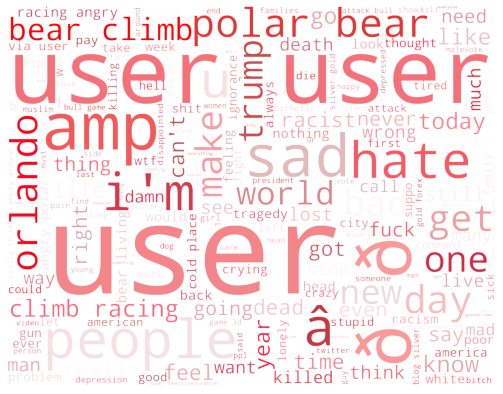

In [114]:
# Une todos los comentarios en un solo texto (formato de la librería)
negative_words =' '.join([text for text in negative_texts])

# Se contruye la nuba de palabras
wordcloud = WordCloud(
    background_color='rgba(255,255,255,0)', mode='RGBA',
    width=1800, height=1400,
    stopwords=set(stopwords.words("english"))
).generate(negative_words)
# Le damos color a las palabras
wordcloud.recolor(color_func=red_color_func, random_state=3)

# Utilizamos matplotlib para visualizar la imagen generada
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

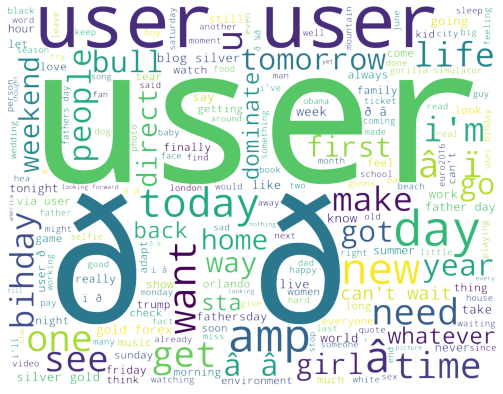

In [115]:
# Une todos los comentarios en un solo texto (formato de la librería)
neutral_words =' '.join([text for text in neutral_texts])

# Se contruye la nuba de palabras
wordcloud = WordCloud(
    background_color='rgba(255,255,255,0)', mode='RGBA',
    width=1800, height=1400,
    stopwords=set(stopwords.words("english"))
).generate(neutral_words)

# Utilizamos matplotlib para visualizar la imagen generada
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Tambien podemos utilizar variables temporales para hacer un monitoreo del sentimiento en diferentes fechas ...

In [116]:
# Agregamos la columna sentimiento
df['sent-py_sentiment'] = new_sentiment
df.head()

,id,tweet,sent-py_sentiment
0,31963,#studiolife #aislife #requires #passion #dedic...,0.4588
1,31964,@user #white #supremacists want everyone to s...,-0.1779
2,31965,safe ways to heal your #acne!! #altwaystohe...,0.7762
3,31966,is the hp and the cursed child book up for res...,0.7383
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0.8883


In [117]:
df.iloc[0][1]

'#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ\x80¦ '

In [118]:
print(' ')
print(' '.join([''] * 10) + 'BUENOS ✅' + ' '.join([''] * 50) + 'MALOS ❌')
print(' ')

limite = 0
for e,f in list(zip(positive_texts,negative_texts)):
    toPrint1 = e + ' ==>  %.5f' % sid.polarity_scores(e).get('compound')
    toPrint2 = f + ' ==>  %.5f' % sid.polarity_scores(f).get('compound')
    print(toPrint1 + ' '.join([''] * (57-len(toPrint1))) + '✅ '+ toPrint2 +'❌')
    limite+=1
    if limite >= 10:
        break

 
         BUENOS ✅                                                 MALOS ❌
 
#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦  ==>  0.45880✅ something inside me dies ð¦ð¿â¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ¦  ==>  -0.65970❌
safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!!  ==>  0.77620✅  @user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels   ==>  -0.39760❌
is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite ==>  0.73830✅  @user got my @user limited edition rain or shine set today!!  ! @user @user @user @user  ==>  -0.41680❌
  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦  ==>  0.88830✅  chick gets fucked hottest naked lady  ==>  -0.65970❌
choose to be   :) #momtips  ==>  0.45880                ✅ #orangechicken   

In [198]:
#Extrayendo palabras negativas de los textos negativos
p_texts = positive_texts.reset_index(drop=True)

wc_pw = []

for i in range(len(p_texts)):
    for j in pos_words:
        if j in p_texts[i]:
            wc_pw.append(j)

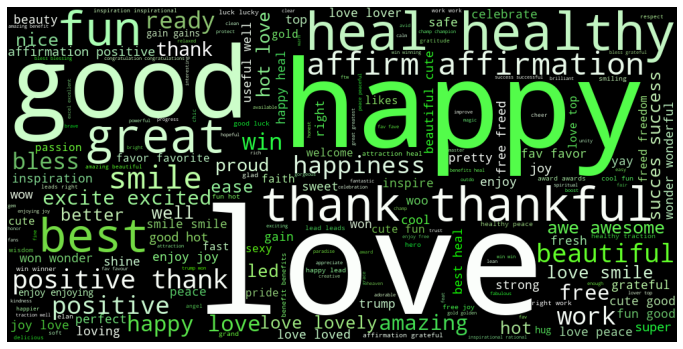

In [208]:
unique_string=(" ").join(wc_pw)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
wordcloud.recolor(color_func=green_color_func, random_state=3)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("wc_pw"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [199]:
#Extrayendo palabras negativas de los textos negativos
n_texts = negative_texts.reset_index(drop=True)

wc_nw = []

for i in range(len(n_texts)):
    for j in neg_words:
        if j in n_texts[i]:
            wc_nw.append(j)

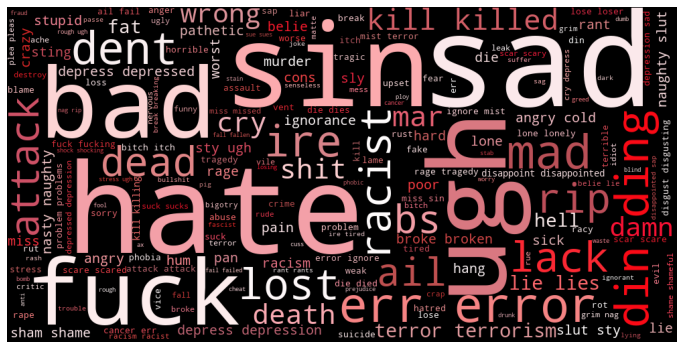

In [209]:
unique_string=(" ").join(wc_nw)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
wordcloud.recolor(color_func=red_color_func, random_state=3)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("wc_nw"+".png", bbox_inches='tight')
plt.show()
plt.close()